# FINAL PROJECT: CHINESE RESTAURANTS IN TORONTO

### DATA 

1. Scrap data from Foursquare API
The data is obtained from foursquare API.We can make free calls (limited and premium) under personal plan. From calls ı obtained venues such as gym, restaurants, clothing stores etc, from surrounding venues.It allows us to analyse the respective business composition and futher inferences the candidates location of interested business category.



In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import folium, requests, geopy, json
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)

In [18]:
def API_credential():
    CLIENT_ID = 'Z5KMAESI12LKB3LJIDDA4OJXPH5MTMIOJNYOC1S5GQFQZLK3'
    CLIENT_SECRET = 'RIHQ2ONOOWR2GYEVQE3HRKRJ1UCFKVGS4NX3N0VZBLE2ACWN'
    URL = 'https://api.foursquare.com/v2/venues/explore'
    return CLIENT_ID, CLIENT_SECRET, URL

In [19]:
def get_data(l, n=100, r=500):
    address = l
    geolocator = geopy.geocoders.Nominatim(user_agent = 'chris')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    CLIENT_ID, CLIENT_SECRET, URL = API_credential()
    LIMIT, RADIUS = n, r
    lat_lon = ','.join(str(i) for i in [latitude, longitude])

    params = dict(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    v = '20180605',
    ll = lat_lon,
    radius = RADIUS,
    limit = LIMIT
    )

    data = requests.get(url=URL, params=params).json()

    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    data_o = json_normalize(data['response']['groups'][0]['items'])[filtered_columns]
    df = pd.DataFrame(data_o)
    cols = [c.split('.')[-1] for c in df.columns]
    df = df.rename(columns=dict(zip(df.columns,cols)))
    df.categories = df.categories.apply(lambda x: x[0]['name'])
    return df

In [20]:

cities = ['london, uk', 'paris, fr', 'new york, us']
df = {}
for city in cities:
    c = city.split(', ')[-1]
    df[c] = get_data(city)
    df[c]['country'] = c.upper()
df = pd.concat([df['uk'],df['fr'],df['us']])

In [21]:
for c in df['country'].unique():
    print('{n} unique categories in {country}'.format(n = df[df['country']==c].categories.value_counts(normalize=True).shape[0], country = c.upper()))

48 unique categories in UK
54 unique categories in FR
59 unique categories in US


# BUSINESS TYPES IN THE CITIES ( UK, FR, US)

In [22]:
for c in df['country'].unique():
    print('\n')
    print('-----'+c.upper()+'-----')
    print(df[df['country']==c].categories.value_counts(normalize=True))



-----UK-----
Theater                       0.080000
Hotel                         0.066667
Japanese Restaurant           0.053333
Art Gallery                   0.040000
Plaza                         0.040000
Wine Bar                      0.026667
Tea Room                      0.026667
Cocktail Bar                  0.026667
Steakhouse                    0.026667
Monument / Landmark           0.026667
Burger Joint                  0.026667
Sandwich Place                0.026667
Garden                        0.026667
Ice Cream Shop                0.026667
English Restaurant            0.026667
Ramen Restaurant              0.026667
Indie Movie Theater           0.013333
Opera House                   0.013333
Currywurst Joint              0.013333
Lebanese Restaurant           0.013333
Restaurant                    0.013333
Bookstore                     0.013333
Toy / Game Store              0.013333
Lounge                        0.013333
Tour Provider                 0.013333
Spa       

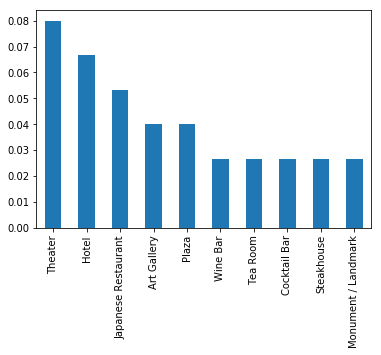

In [23]:
df[df['country']=='UK'].categories.value_counts(normalize=True)[:10].plot.bar()

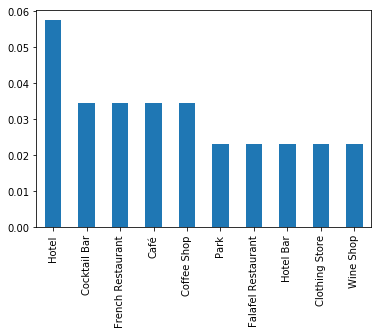

In [24]:
df[df['country']=='US'].categories.value_counts(normalize=True)[:10].plot.bar()

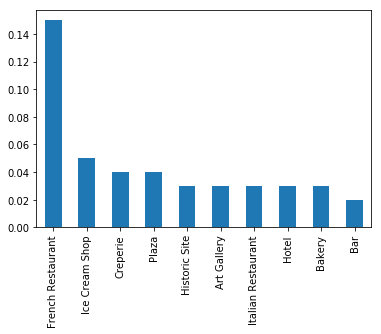

In [25]:
df[df['country']=='FR'].categories.value_counts(normalize=True)[:10].plot.bar()

In [ ]:
From frequency charts above we can observe the most frequent business types of countries.The most frequent category is Theater, French Resturant, Coffee Shop in UK, FR, US respectively

# K-mean clustering attempt and map visualisation


 ## we group them by Kmeans, Map and Pie Visualisation after grouping


In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
df_2 = df.copy()
for c in df.select_dtypes('object'):
    df[c] = LabelEncoder().fit_transform(df[c])
df.head()
k = 4
df['cluster'] = pd.Series(KMeans(n_clusters=k, random_state=5).fit(df).labels_)
df['cluster'].value_counts(normalize=True)

3    0.454198
0    0.293893
2    0.251908
Name: cluster, dtype: float64

In [27]:

df_2['cluster'] = df['cluster']
df_2.head()

,name,categories,lat,lng,country,cluster
0,National Gallery,Art Museum,51.508876,-0.128478,UK,0
1,Trafalgar Square,Plaza,51.507987,-0.128048,UK,3
2,East Trafalgar Square Fountain,Fountain,51.508088,-0.127700,UK,2
3,Corinthia Hotel,Hotel,51.506607,-0.124460,UK,2
4,National Portrait Gallery,Art Gallery,51.509438,-0.128032,UK,0


In [28]:

sorted(df_2['cluster'].unique())

[0, 2, 3]

In [29]:

def map_vis(a, c, df=df_2, Q='cluster'):
    address = ', '.join([a,c])
    geolocator = geopy.geocoders.Nominatim(user_agent = 'chris')
    location = geolocator.geocode(a)
    latitude = location.latitude
    longitude = location.longitude

    map = folium.Map(location = [latitude,longitude], zoom_start=15)

    df_c = df[df.country==c.upper()]
    for q, color in zip(sorted(df_c[Q].unique()), ['blue', 'orange', 'green']):
        for lat, lon in zip(df_c[df_c[Q]==q].lat, df_c[df_c[Q]==q].lng):
            folium.CircleMarker(
                [lat,lon],
                radius = 5,
                color = color,
                fill_color = color,
                popup = folium.Popup(str(q), parse_html=True),
                fill_opacity=0.3
                ).add_to(map)
    return map

In [30]:

map_vis('london','uk')

In [31]:
map_vis('paris','fr')

In [32]:
map_vis('new york','us')


# Regrouping
## The K-means clustering does not provide obvious insight, we shall label the categories into following general gropus, namely: DİNİNG-RETAİL-OTHERS


In [33]:

def CRO(r):
    import re
    catering_boo = df_2['categories'].str.contains(r'bar|Restaurant|place|coffee|yogurt|dessert|ice cream|Bagel|Wine|Bistro|Bakery|Café|Pub|Cupcake|Tea|Liquor', flags=re.I) # there must be a better way for this..
    retail_boo = df_2['categories'].str.contains(r'shop|store', flags=re.I) & ~catering_boo
    other_boo = ~catering_boo & ~retail_boo
    catering_cat = df_2[catering_boo]['categories'].unique()
    retail_cat = df_2[retail_boo]['categories'].unique()

    if r in catering_cat:
        return 'Dining'
    elif r in retail_cat:
        return 'Retail'
    else: 
        return 'Others'

df_2.head()

,name,categories,lat,lng,country,cluster
0,National Gallery,Art Museum,51.508876,-0.128478,UK,0
1,Trafalgar Square,Plaza,51.507987,-0.128048,UK,3
2,East Trafalgar Square Fountain,Fountain,51.508088,-0.127700,UK,2
3,Corinthia Hotel,Hotel,51.506607,-0.124460,UK,2
4,National Portrait Gallery,Art Gallery,51.509438,-0.128032,UK,0


# Overall Business Types

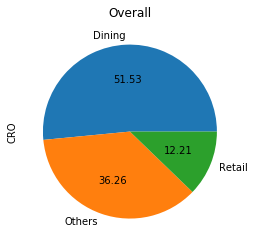

In [34]:
df_2['CRO'] = df_2['categories'].apply(CRO)
df_2.CRO.value_counts(normalize=True).plot.pie(autopct = '%.2f')
plt.title('Overall')
plt.show()

Overall, over 50% of the catergory is 'dining', over one-third of the catergory falls into 'others', and only about 15% of category is 'retail'.Category of 'dining' has highly competitive market.

# Business types by countries

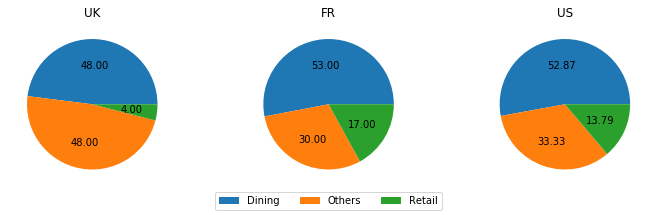

In [35]:
r, c = 1, df_2.country.unique().shape[0]
fig, ax = plt.subplots(r, c, figsize = (12,3))
for j, n in zip(range(c), df_2.country.unique()):
    ax[j].set_title(n)
    ax[j].pie(df_2[df_2.country==n]['CRO'].value_counts(normalize=True), autopct = '%.2f')
    labels = df_2[df_2.country==n]['CRO'].value_counts(normalize=True).index
fig.legend(labels, loc = 8, ncol=c)
fig.show()

-'Dining category has the biggest shares among other categories. It remains in the first place in both 3 countries
-Dining has a biggest sharen in France than other countries.
-'Other' category has relatively superior in UK than FR and US

In [36]:
map_vis('london', 'uk', Q='CRO')

In [37]:
map_vis('paris', 'fr', Q='CRO')

In [38]:
map_vis('new york', 'us', Q='CRO')

In [39]:
df_2['CRO_num'] = pd.Series(LabelEncoder().fit_transform(df_2['CRO']))
df_2[['CRO_num','cluster']].corr()
# the correlation of the kmean cluster is very less correlated with the general categories

,CRO_num,cluster
CRO_num,1.000000,-0.069296
cluster,-0.069296,1.000000


In [ ]:
The above map visualisations reveal the following neigborhood information:

-Dining business is usually close to each other all selected countries
-UK Dining business is relatively spared and is surrounded by 'other' venues, such as national gallery and museum
-FR Dining business is surrounded by retail businesses, and more compact than UK
-US composition is relatively compact than the UK and FR, different category venues are close to each other.

# Conclusion

Descriptively, for catering business,FR and US prefers convenience. for business opportuntiy, UK has potential in retail given its similarity composition with US.Certainly, this study is prelimiary and descriptive, it has less predictive power. It could be more interesting there is time series data of the business composition, such that we could observe the change in a particular business type and the business cycle, however, finding the data source is extremely time consuming without piror knowledge.Given the current dataset, more detail analysis could be done by diging deeper to the composition of each category such as the genre of catering business, and retail business.